# Data cleaning exploration

If you are reading this, great! We hoopefully have some good results!

EDIT: hehe nop, something is really wrong. Someone find it please

We start by loading the data and the requried libraries:

In [511]:
import pandas as pd 
import numpy as np
from scipy import stats #not used atm
data = pd.read_csv("data/consumption_temp.csv")

In [512]:
data.head(5) , data.describe() , data.shape

(                  time   location  consumption  temperature
 0  2022-04-07 21:00:00     bergen     1.113325         -0.3
 1  2022-04-07 21:00:00       oslo     4.092830          1.0
 2  2022-04-07 21:00:00  stavanger     2.057858          1.3
 3  2022-04-07 21:00:00     tromsø     1.246582         -3.9
 4  2022-04-07 21:00:00  trondheim     1.970098         -2.8,
         consumption   temperature
 count  49494.000000  49494.000000
 mean       3.509242      6.554019
 std        3.096356      7.630308
 min        0.000000    -17.299999
 25%        1.263256      1.000000
 50%        2.376530      6.800000
 75%        5.189000     12.100000
 max       18.045011     30.500000,
 (49494, 4))

Looking at some of the dataframe observations, we should have a timestamp for each hour of each location (We need to check for missing values at a later point). We also have the temprature for the time and location, as well as the corresponding consumption for that hour. 

For the summary, there is not much to comment on. Lastly, we have 49,5k observations.

In [513]:
locations = data["location"].unique()
print(locations)
min_date = data["time"].min()
max_date = data["time"].max()
min_date , max_date

['bergen' 'oslo' 'stavanger' 'tromsø' 'trondheim' 'helsingfors']


('2022-04-07 21:00:00', '2023-04-02 21:00:00')

First of all, what does Hellsinki do here? We should remove this location at a later point.

We also note that we have roughly an year of observations from spring 2022 to spirng 2023.

## Manipulate the data

Next, we try to manipulate our data into a dataframe which corresponds to what information is avaliable

In [514]:


df = data.sort_values(by=['location', 'time'])
df["time"] = pd.to_datetime(df["time"])
# Calculate consumption means with shift
hours_shift_back = 4 * 24 + 11  #4 days back, plus the shift back to midnight.As in the example by ANEA, we shift from 10:00 september 19 to 23:00 septembeer 13
df["consumption-5_mean_lag_1d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 1).mean()
df["consumption-5_mean_lag_3d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 3).mean()
df["consumption-5_mean_lag_7d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 7).mean()
df["consumption-5_mean_lag_14d"] = df.groupby('location')['consumption'].shift(hours_shift_back).rolling(window=24 * 14).mean()

# Calculate temperature means with shift
hours_shift_forward = 13  ##takes the time from 10:00 to 23:00 the same day
df["temperature_mean_lag_1d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 1).mean()
df["temperature_mean_lag_3d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 3).mean()
df["temperature_mean_lag_7d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 7).mean()
df["temperature_mean_lag_14d"] = df.groupby('location')['temperature'].shift(hours_shift_forward).rolling(window=24 * 14).mean()

df_days_before = df[df["time"].dt.time == pd.to_datetime("10:00:00").time()]                 # we only need the historic values at 10:00
df_days_before.dropna(inplace=True)                                                     #For some dates we do not have the amount of data to calculate the means, we therefore drop them
df_days_before["date_of_prediction"] = pd.to_datetime((df_days_before["time"].dt.date)) - pd.Timedelta(days = 1)                 # the date of which the prediction was made
df_days_before.drop(columns=["consumption","temperature","time"],inplace=True)                 # Not relevant for the days before


df_days_before



C:\Users\marti\AppData\Local\Temp\ipykernel_19440\1396107245.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_days_before.dropna(inplace=True)                                                     #For some dates we do not have the amount of data to calculate the means, we therefore drop them
C:\Users\marti\AppData\Local\Temp\ipykernel_19440\1396107245.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_days_before["date_of_prediction"] = pd.to_datetime((df_days_before["time"].dt.date)) - pd.Timedelta(days = 1)                 # the date of which the pre

,location,consumption-5_mean_lag_1d,consumption-5_mean_lag_3d,consumption-5_mean_lag_7d,consumption-5_mean_lag_14d,temperature_mean_lag_1d,temperature_mean_lag_3d,temperature_mean_lag_7d,temperature_mean_lag_14d,date_of_prediction
2225,bergen,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,2022-04-25
2345,bergen,0.639986,0.657868,0.754460,0.876003,9.462500,9.065278,10.716071,9.549702,2022-04-26
2465,bergen,0.642043,0.641840,0.719620,0.843445,6.970833,8.338889,10.187500,9.664881,2022-04-27
2585,bergen,0.685941,0.655990,0.694794,0.815257,6.741667,7.725000,9.341071,9.544940,2022-04-28
2705,bergen,0.685496,0.671160,0.675393,0.790305,6.625000,6.779167,8.419048,9.424702,2022-04-29
...,...,...,...,...,...,...,...,...,...,...
48851,trondheim,3.294686,3.249709,3.260476,3.496551,-5.883333,-4.602778,-2.030357,-0.492262,2023-03-28
48995,trondheim,3.357346,3.279704,3.258204,3.443140,-6.137500,-5.304167,-2.976786,-0.928274,2023-03-29
49139,trondheim,3.655065,3.435699,3.289676,3.415028,-5.308333,-5.776389,-3.946429,-1.232143,2023-03-30
49283,trondheim,3.423687,3.478699,3.332731,3.393111,-2.983333,-4.809722,-4.510119,-1.644345,2023-03-31


This dataframe contains historic value that we can use for our predictions each day. Note that the lag values for consiumptions starts 5 days a head of the day which we are predicting for. This is due to the restriction in the given problem. The temperatur, however, has the lags from the same day of the prediction.


Next up, we have to combine our historic data with each hours prediction ahead in time. Since we also have the temprature forecasts a head of time, we can use the current forcasted value, as well as the previous hours.

In [385]:
df = data.sort_values(by=["location", "time"])
df["temperature_mean_lag_1h"] = df.groupby("location")["temperature"].shift(1).rolling(window=1).mean()
df["temperature_mean_lag_3h"] = df.groupby("location")["temperature"].shift(1).rolling(window=3).mean()
df["temperature_mean_lag_6h"] = df.groupby("location")["temperature"].shift(1).rolling(window=6).mean()
df["date_of_prediction"] = pd.to_datetime(df["time"].dt.date) - pd.Timedelta(days=1)
df_full = df.merge(df_days_before,on=["date_of_prediction","location"])
df_full

,time,location,consumption,temperature,temperature_mean_lag_1h,temperature_mean_lag_3h,temperature_mean_lag_6h,date_of_prediction,consumption-5_mean_lag_1d,consumption-5_mean_lag_3d,consumption-5_mean_lag_7d,consumption-5_mean_lag_14d,temperature_mean_lag_1d,temperature_mean_lag_3d,temperature_mean_lag_7d,temperature_mean_lag_14d
0,2022-04-26 00:00:00,bergen,0.583449,4.0,4.1,4.233333,6.166667,2022-04-25,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
1,2022-04-26 01:00:00,bergen,0.597281,3.3,4.0,4.033333,5.133333,2022-04-25,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
2,2022-04-26 02:00:00,bergen,0.592792,2.9,3.3,3.800000,4.350000,2022-04-25,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
3,2022-04-26 03:00:00,bergen,0.604434,2.9,2.9,3.400000,3.816667,2022-04-25,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
4,2022-04-26 04:00:00,bergen,0.664663,2.6,2.9,3.033333,3.533333,2022-04-25,0.643492,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46879,2023-04-02 17:00:00,trondheim,3.927136,3.6,5.9,6.366667,6.400000,2023-04-01,3.619001,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46880,2023-04-02 18:00:00,trondheim,4.067940,3.0,3.6,5.400000,6.033333,2023-04-01,3.619001,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46881,2023-04-02 19:00:00,trondheim,4.093120,1.4,3.0,4.166667,5.433333,2023-04-01,3.619001,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119
46882,2023-04-02 20:00:00,trondheim,3.990767,-2.7,1.4,2.666667,4.516667,2023-04-01,3.619001,3.565918,3.400604,3.393061,-2.000000,-3.430556,-4.319643,-1.960119


If we merge these two frames, we get the historic information for each variable timepoint we are predicting.

In [ ]:
df_full = df.merge(df_days_before,on=["date_of_prediction","location"])
df_full

## Extract info from date

Firsty, we check if the datatypes match, which they do.

In [386]:
df_full.dtypes

time                          datetime64[ns]
location                              object
consumption                          float64
temperature                          float64
temperature_mean_lag_1h              float64
temperature_mean_lag_3h              float64
temperature_mean_lag_6h              float64
date_of_prediction            datetime64[ns]
consumption-5_mean_lag_1d            float64
consumption-5_mean_lag_3d            float64
consumption-5_mean_lag_7d            float64
consumption-5_mean_lag_14d           float64
temperature_mean_lag_1d              float64
temperature_mean_lag_3d              float64
temperature_mean_lag_7d              float64
temperature_mean_lag_14d             float64
dtype: object

We add some important feautures from the date

In [435]:
df_full["day_of_week"] = df_full["time"].dt.dayofweek
df_full["day_of_year"] = df_full["time"].dt.dayofyear
df_full["hour_of_day"] = df_full["time"].dt.hour


time                          datetime64[ns]
location                              object
consumption                          float64
temperature                          float64
temperature_mean_lag_1h              float64
temperature_mean_lag_3h              float64
temperature_mean_lag_6h              float64
date_of_prediction            datetime64[ns]
consumption-5_mean_lag_1d            float64
consumption-5_mean_lag_3d            float64
consumption-5_mean_lag_7d            float64
consumption-5_mean_lag_14d           float64
temperature_mean_lag_1d              float64
temperature_mean_lag_3d              float64
temperature_mean_lag_7d              float64
temperature_mean_lag_14d             float64
day_of_week                            int32
day_of_year                            int32
hour_of_day                            int32
dtype: object

Time to test with 5-fold cross validation

In [502]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Drop columns not used in regression
df = df_full.drop(columns=["time", "date_of_prediction"])
# Encode categorical variable "location" using one-hot encoding
df = pd.get_dummies(df, columns=["location"], drop_first=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the hyperparameters as needed

# Define the number of folds for cross-validation
k_folds = 5  # Adjust as needed

# Create a KFold object for cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
X = df.drop(columns=["consumption"])
y = df["consumption"]
# Perform k-fold cross-validation
mae_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# Calculate the mean MAE score
mean_mae_score = -mae_scores.mean()

# Print the RMSE for each fold
for i, rmse in enumerate(mae_scores):
    print(f"Fold {i+1} RMSE: {rmse:.2f}")

# Calculate and print the mean RMSE across all folds
mae_rmse = np.mean(mae_scores)
print(f"Mean RMSE: {mae_rmse:.2f}")


Fold 1 RMSE: -0.08
Fold 2 RMSE: -0.08
Fold 3 RMSE: -0.07
Fold 4 RMSE: -0.08
Fold 5 RMSE: -0.08
Mean RMSE: -0.08


Nice, we have a low error i guess

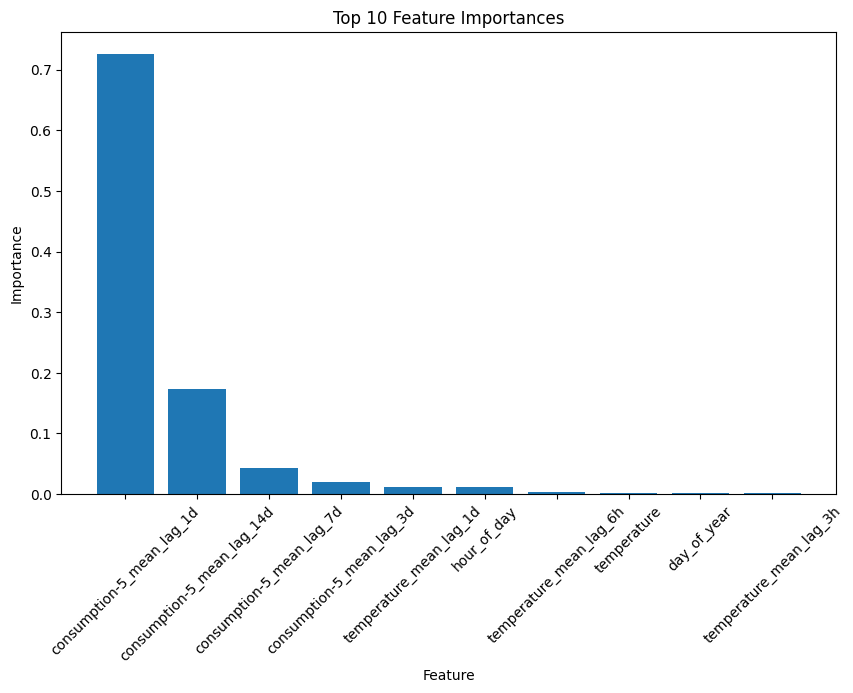

Index(['consumption-5_mean_lag_1d', 'consumption-5_mean_lag_14d',
       'consumption-5_mean_lag_7d', 'consumption-5_mean_lag_3d',
       'temperature_mean_lag_1d', 'hour_of_day', 'temperature_mean_lag_6h',
       'temperature', 'day_of_year', 'temperature_mean_lag_3h',
       'temperature_mean_lag_14d', 'temperature_mean_lag_1h',
       'temperature_mean_lag_3d', 'temperature_mean_lag_7d', 'location_oslo',
       'day_of_week', 'location_stavanger', 'location_tromsø',
       'location_helsingfors', 'location_trondheim'],
      dtype='object')

In [499]:
X = df.drop(columns=["consumption"])

y = df["consumption"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X,y)
feature_importances = model.feature_importances_

# Get the feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = (-feature_importances).argsort()

# Number of top features to display
N = 10  # Change this number to display the top N features

# Create a bar plot for the top N features
plt.figure(figsize=(10, 6))
plt.title("Top {} Feature Importances".format(N))
plt.bar(range(N), feature_importances[indices[:N]], align="center")
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
feature_names[indices]

Why the lag 1 day lag 5 days ago so important??!?!?


If we fit a linear regression with only this lag, we actually get a good R-squared

In [500]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame called 'data' with your variables and target
# Replace 'X' with your feature matrix and 'y' with your target variable
X = df.drop(columns=["consumption"])
X = X[["consumption-5_mean_lag_1d"]]
y = df["consumption"]
# Add a constant term to the feature matrix for the intercept
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Print a summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 9.367e+05
Date:                Sun, 22 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:05:10   Log-Likelihood:                -48881.
No. Observations:               46884   AIC:                         9.777e+04
Df Residuals:                   46882   BIC:                         9.778e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 